In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from utils.data import load_tc_data
from utils.plot import make_cmap



In [3]:
# load dataset
# load data
def generate_composite_rainfall(meta,rain,ibtracks=False,time_sample_rate=False,rain_rate=False,ssp585=True):
	
	# get subset of storms
	sids = meta.sid
	# print(sids)
	if ssp585 == True:
		bool = [yr in range(2069,2100) for yr in meta.year]
		print(bool)
		sids = meta.loc[bool, 'sid']
		print(sids)

	sids_unique=sids.drop_duplicates()
	nstorms = len(sids_unique)
	# avg_timesteps = len(sids)/nstorms
	tracks_grouped = meta.groupby('sid')
	composite_storm_rain = np.zeros((nstorms,100,100))
	i=0
	drop_idx=[]
	south_idx=[]
	north_idx=[]
	# find time frequency
	for sid in sids_unique:
		storm = tracks_grouped.get_group(sid)
		if ibtracks != False:
			storm_full = ibtracks.get_group(sid)
		else:
			storm_full = storm

		if time_sample_rate==False:
			
			hourly_rate=[]
			for h in storm_full.hour:
				if h in [3,9,15,21]:
					hour_rate = 3
				elif h in [0,6,12,18]:
					hour_rate = 6
				else:
					hour_rate = 0
				
				hourly_rate.append(hour_rate)

			# calculate hourly rates
			if set(hourly_rate) == {3,6}:
				# calculate storm duration as time rate (3 or 6 hourly time points) * number of time points
				storm_duration = 3 * len(storm) # this gives how many hours storm was alive for as a TC
				# define unit converstion as rain/storm_duration (number of hours) * 24 to get daily rain rate
				units_converter = 24/storm_duration

			elif 6 in set(hourly_rate): # so this means one datapoint every 6 hours
				storm_duration = 6 * len(storm) # this gives how many hours storm was alive for as a TC
				# need to multiply the rain by 2 because units are mm/3h, right now only accounting for half the rain, so multiplying by 2 is interpolating for rain between values
				units_converter = 24 * 2/storm_duration
			else:
				print('storm set is strange')
				print(set(hourly_rate))
				units_converter = 0
		else:
			
			storm_duration = time_sample_rate * len(storm)
			# if rain_rate == False: # if rain is sampled at same time as track
			units_converter = 24 / storm_duration
			# else: # otherwise rain is counted 3 hourly so needs to be doubled as tracks are counted 6 hourly so we're missing out on half the rain
			# 	units_converter = 24*rain_rate / storm_duration

		storm_lats = storm.centre_lat
		storm_lons = storm.centre_lon
		# print(storm.index)
		storm_rain = rain[storm.index,:,:,0]
		mean_storm_rain = np.sum(storm_rain,axis=0)*units_converter
		# storm_month = storm.month
		# storm_year = storm.year
		# storm_v = storm.v
		if units_converter == 0:
			drop_idx.append(i)
		else:
			if np.sum(storm_lats) < 0:
				south_idx.append(i)
			else:
				north_idx.append(i)
		

		composite_storm_rain[i,:,:] = mean_storm_rain
		i=i+1

	# save plottable dataset
	# composite_rainfall = calculate_composite_rainfall()
	# delete timestamps we can't use
	# np.delete(composite_storm_rain,drop_idx,axis=0)
	# get nh and sh datasets
	composite_storm_rain_nh = composite_storm_rain[north_idx,:,:]
	composite_storm_rain_sh = composite_storm_rain[south_idx,:,:]
	# print(composite_storm_rain.shape)
	# print(composite_storm_rain_nh.shape)
	# print(composite_storm_rain_sh.shape)
	composite_nh = np.mean(composite_storm_rain_nh,axis=0)
	composite_sh = np.mean(composite_storm_rain_sh,axis=0)
	return composite_nh,composite_sh,len(north_idx),len(south_idx)




In [4]:
CMCC_ssp585_NH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/ssp585/storm_sid_NH.csv')

In [5]:
CMCC_ssp585_NH_sids

,Unnamed: 0,sid,year,month,day,hour,centre_lat,centre_lon
0,44,TC_CMCC-CM2-VHR4_ssp585_2015_NH_1,2015,1,31,12,65.827904,-36.5625
1,45,TC_CMCC-CM2-VHR4_ssp585_2015_NH_1,2015,1,31,18,66.531937,-35.9375
2,46,TC_CMCC-CM2-VHR4_ssp585_2015_NH_1,2015,2,1,0,66.531937,-36.5625
3,47,TC_CMCC-CM2-VHR4_ssp585_2015_NH_1,2015,2,1,6,66.062576,-37.1875
4,65,TC_CMCC-CM2-VHR4_ssp585_2015_NH_2,2015,2,23,18,38.604950,165.0000
...,...,...,...,...,...,...,...,...
5751,176084,TC_CMCC-CM2-VHR4_ssp585_2049_NH_2883,2049,12,21,18,5.514994,165.9375
5752,176085,TC_CMCC-CM2-VHR4_ssp585_2049_NH_2883,2049,12,22,0,5.749674,165.0000
5753,176086,TC_CMCC-CM2-VHR4_ssp585_2049_NH_2883,2049,12,22,6,5.514994,163.7500
5754,176089,TC_CMCC-CM2-VHR4_ssp585_2049_NH_2883,2049,12,23,0,6.219035,161.5625


In [6]:
# load current 1D dataset
real,inputs,pred,meta = load_tc_data(set='validation',results='ke_tracks')

# load ibtracks
tracks = pd.read_csv('/user/home/al18709/work/ibtracks/tc_files.csv')
og_tracks_grouped = tracks.groupby('sid')

# load original 2D WGAN
real_2,inputs_2,pred_2,meta_2,imput_og,pred_og,meta_og = load_tc_data(set='validation',results='kh_tracks')
real_og_x,_,_,_,_,_,pred_og_x,meta_og_x = load_tc_data(set='extreme_test',results='test')
meta_og = pd.read_csv('/user/work/al18709/tc_data_mswep_40/valid_meta.csv')
# meta_valid = pd.read_csv('/user/work/al18709/tc_data_flipped/valid_meta.csv')

# # load HighResMIP CMCC-CM2-VHR4 ssp585 NH
CMCC_ssp585_NH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/ssp585/storm_rain_NH.npy')
CMCC_ssp585_NH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/ssp585/storm_lats_NH.npy')
CMCC_ssp585_NH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/ssp585/storm_lons_NH.npy')
CMCC_ssp585_NH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/ssp585/storm_sid_NH.csv')
indices = (CMCC_ssp585_NH_sids['year'] >= 2035) & (CMCC_ssp585_NH_sids['year'] <= 2049)
CMCC_ssp585_NH_sids = CMCC_ssp585_NH_sids[indices].reset_index()
CMCC_ssp585_NH_rain = CMCC_ssp585_NH_rain[indices]
CMCC_ssp585_NH_lats = CMCC_ssp585_NH_lats[indices]
CMCC_ssp585_NH_lons = CMCC_ssp585_NH_lons[indices]
meta_CMCC_ssp585_NH = pd.DataFrame({'sid':CMCC_ssp585_NH_sids.sid ,'centre_lat':CMCC_ssp585_NH_lats[:,4], 'centre_lon':CMCC_ssp585_NH_lons[:,4], 'year':CMCC_ssp585_NH_sids.year})

# # load HighResMIP CMCC-CM2-VHR4 ssp585 SH
CMCC_ssp585_SH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/ssp585/storm_rain_SH.npy')
CMCC_ssp585_SH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/ssp585/storm_lats_SH.npy')
CMCC_ssp585_SH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/ssp585/storm_lons_SH.npy')
CMCC_ssp585_SH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/ssp585/storm_sid_SH.csv')
print(CMCC_ssp585_SH_sids.sid.shape)
indices = (CMCC_ssp585_SH_sids['year'] >= 2035) & (CMCC_ssp585_SH_sids['year'] <= 2049)
CMCC_ssp585_SH_sids = CMCC_ssp585_SH_sids[indices].reset_index()
CMCC_ssp585_SH_rain = CMCC_ssp585_SH_rain[indices]
CMCC_ssp585_SH_lats = CMCC_ssp585_SH_lats[indices]
CMCC_ssp585_SH_lons = CMCC_ssp585_SH_lons[indices]
meta_CMCC_ssp585_SH = pd.DataFrame({'sid':CMCC_ssp585_SH_sids.sid ,'centre_lat':CMCC_ssp585_SH_lats[:,4], 'centre_lon':CMCC_ssp585_SH_lons[:,4]})

# # load HighResMIP EC-EARTH-3P-HR  ssp585 NH
ecearthhr_ssp585_NH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/ssp585/storm_rain_NH.npy')
ecearthhr_ssp585_NH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/ssp585/storm_lats_NH.npy')
ecearthhr_ssp585_NH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/ssp585/storm_lons_NH.npy')
ecearthhr_ssp585_NH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/ssp585/storm_sid_NH.csv')
print(ecearthhr_ssp585_NH_sids.sid.shape)
indices = (ecearthhr_ssp585_NH_sids['year'] >= 2035) & (ecearthhr_ssp585_NH_sids['year'] <= 2049)
ecearthhr_ssp585_NH_sids = ecearthhr_ssp585_NH_sids[indices].reset_index()
ecearthhr_ssp585_NH_rain = ecearthhr_ssp585_NH_rain[indices]
ecearthhr_ssp585_NH_lats = ecearthhr_ssp585_NH_lats[indices]
ecearthhr_ssp585_NH_lons = ecearthhr_ssp585_NH_lons[indices]
meta_ecearthhr_ssp585_NH = pd.DataFrame({'sid':ecearthhr_ssp585_NH_sids.sid ,'centre_lat':ecearthhr_ssp585_NH_lats[:,4], 'centre_lon':ecearthhr_ssp585_NH_lons[:,4], 'year': ecearthhr_ssp585_NH_sids.year})

# # load HighResMIP EC-EARTH-3P-HR ssp585 SH
ecearthhr_ssp585_SH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/ssp585/storm_rain_SH.npy')
ecearthhr_ssp585_SH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/ssp585/storm_lats_SH.npy')
ecearthhr_ssp585_SH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/ssp585/storm_lons_SH.npy')
ecearthhr_ssp585_SH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/ssp585/storm_sid_SH.csv')
print(ecearthhr_ssp585_SH_sids.sid.shape)
indices = (ecearthhr_ssp585_SH_sids['year'] >= 2035) & (ecearthhr_ssp585_SH_sids['year'] <= 2049)
ecearthhr_ssp585_SH_sids = ecearthhr_ssp585_SH_sids[indices].reset_index()
ecearthhr_ssp585_SH_rain = ecearthhr_ssp585_SH_rain[indices]
ecearthhr_ssp585_SH_lats = ecearthhr_ssp585_SH_lats[indices]
ecearthhr_ssp585_SH_lons = ecearthhr_ssp585_SH_lons[indices]
meta_ecearthhr_ssp585_SH = pd.DataFrame({'sid':ecearthhr_ssp585_SH_sids.sid ,'centre_lat':ecearthhr_ssp585_SH_lats[:,4], 'centre_lon':ecearthhr_ssp585_SH_lons[:,4], 'year':ecearthhr_ssp585_SH_sids.year})

# # load HighResMIP HadGEM3-GC31-HM ssp585 NH
hadgem_ssp585_NH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/ssp585/storm_rain_NH.npy')
hadgem_ssp585_NH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/ssp585/storm_lats_NH.npy')
hadgem_ssp585_NH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/ssp585/storm_lons_NH.npy')
hadgem_ssp585_NH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/ssp585/storm_sid_NH.csv')
print(hadgem_ssp585_NH_sids.sid.shape)
indices = (hadgem_ssp585_NH_sids['year'] >= 2035) & (hadgem_ssp585_NH_sids['year'] <= 2049)
hadgem_ssp585_NH_sids = hadgem_ssp585_NH_sids[indices].reset_index()
hadgem_ssp585_NH_rain = hadgem_ssp585_NH_rain[indices]
hadgem_ssp585_NH_lats = hadgem_ssp585_NH_lats[indices]
hadgem_ssp585_NH_lons = hadgem_ssp585_NH_lons[indices]
meta_hadgem_ssp585_NH = pd.DataFrame({'sid':hadgem_ssp585_NH_sids.sid ,'centre_lat':hadgem_ssp585_NH_lats[:,4], 'centre_lon':hadgem_ssp585_NH_lons[:,4], 'year': hadgem_ssp585_NH_sids.year})

# # # load HighResMIP HadGEM3-GC31-HM ssp585 SH
hadgem_ssp585_SH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/ssp585/storm_rain_SH.npy')
hadgem_ssp585_SH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/ssp585/storm_lats_SH.npy')
hadgem_ssp585_SH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/ssp585/storm_lons_SH.npy')
hadgem_ssp585_SH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/ssp585/storm_sid_SH.csv')
print(hadgem_ssp585_SH_sids.sid.shape)
indices = (hadgem_ssp585_SH_sids['year'] >= 2035) & (hadgem_ssp585_SH_sids['year'] <= 2049)
hadgem_ssp585_SH_sids = hadgem_ssp585_SH_sids[indices].reset_index()
hadgem_ssp585_SH_rain = hadgem_ssp585_SH_rain[indices]
hadgem_ssp585_SH_lats = hadgem_ssp585_SH_lats[indices]
hadgem_ssp585_SH_lons = hadgem_ssp585_SH_lons[indices]
meta_hadgem_ssp585_SH = pd.DataFrame({'sid':hadgem_ssp585_SH_sids.sid ,'centre_lat':hadgem_ssp585_SH_lats[:,4], 'centre_lon':hadgem_ssp585_SH_lons[:,4], 'year':hadgem_ssp585_SH_sids.year})


year1 = 2085
year2 = 2099
# # load CMIP6 ssp585 dataset 
miroc6_ssp585_rain = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/ssp585/storm_rain_NH.npy')
miroc6_ssp585_lats = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/ssp585/storm_lats_NH.npy')
miroc6_ssp585_lons = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/ssp585/storm_lons_NH.npy')
miroc6_ssp585_sids = pd.read_csv('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/ssp585/storm_sid_NH.csv')
indices = (miroc6_ssp585_sids['year'] >= year1) & (miroc6_ssp585_sids['year'] <= year2)
miroc6_ssp585_sids = miroc6_ssp585_sids[indices].reset_index()
miroc6_ssp585_rain = miroc6_ssp585_rain[indices]
miroc6_ssp585_lats = miroc6_ssp585_lats[indices]
miroc6_ssp585_lons = miroc6_ssp585_lons[indices]
meta_miroc6_ssp585 = pd.DataFrame({'sid':miroc6_ssp585_sids.sid ,'centre_lat':miroc6_ssp585_lats[:,4], 'centre_lon':miroc6_ssp585_lons[:,4], 'year':miroc6_ssp585_sids.year})

miroc6_ssp585_rain_SH = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/ssp585/storm_rain_SH.npy')
miroc6_ssp585_lats_SH = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/ssp585/storm_lats_SH.npy')
miroc6_ssp585_lons_SH = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/ssp585/storm_lons_SH.npy')
miroc6_ssp585_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/ssp585/storm_sid_SH.csv')
indices = (miroc6_ssp585_sids_SH['year'] >= year1) & (miroc6_ssp585_sids_SH['year'] <= year2)
miroc6_ssp585_sids_SH = miroc6_ssp585_sids_SH[indices].reset_index()
miroc6_ssp585_rain_SH = miroc6_ssp585_rain_SH[indices]
miroc6_ssp585_lats_SH = miroc6_ssp585_lats_SH[indices]
miroc6_ssp585_lons_SH = miroc6_ssp585_lons_SH[indices]
meta_miroc6_ssp585_SH = pd.DataFrame({'sid':miroc6_ssp585_sids_SH.sid ,'centre_lat':miroc6_ssp585_lats_SH[:,4], 'centre_lon':miroc6_ssp585_lons_SH[:,4], 'year':miroc6_ssp585_sids_SH.year})

# CMIP6 MPI-ESM1-2-LR
mpi_ssp585_rain = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/ssp585/storm_rain_NH.npy')
mpi_ssp585_lats = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/ssp585/storm_lats_NH.npy')
mpi_ssp585_lons = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/ssp585/storm_lons_NH.npy')
mpi_ssp585_sids = pd.read_csv('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/ssp585/storm_sid_NH.csv')
indices = (mpi_ssp585_sids['year'] >= year1) & (mpi_ssp585_sids['year'] <= year2)
mpi_ssp585_sids = mpi_ssp585_sids[indices].reset_index()
mpi_ssp585_rain = mpi_ssp585_rain[indices]
mpi_ssp585_lats = mpi_ssp585_lats[indices]
mpi_ssp585_lons = mpi_ssp585_lons[indices]
meta_mpi_ssp585 = pd.DataFrame({'sid':mpi_ssp585_sids.sid ,'centre_lat':mpi_ssp585_lats[:,4], 'centre_lon':mpi_ssp585_lons[:,4], 'year':mpi_ssp585_sids.year})

mpi_ssp585_rain_SH = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/ssp585/storm_rain_SH.npy')
mpi_ssp585_lats_SH = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/ssp585/storm_lats_SH.npy')
mpi_ssp585_lons_SH = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/ssp585/storm_lons_SH.npy')
mpi_ssp585_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/ssp585/storm_sid_SH.csv')
indices = (mpi_ssp585_sids_SH['year'] >= year1) & (mpi_ssp585_sids_SH['year'] <= year2)
mpi_ssp585_sids_SH = mpi_ssp585_sids_SH[indices].reset_index()
mpi_ssp585_rain_SH = mpi_ssp585_rain_SH[indices]
mpi_ssp585_lats_SH = mpi_ssp585_lats_SH[indices]
mpi_ssp585_lons_SH = mpi_ssp585_lons_SH[indices]
meta_mpi_ssp585_SH = pd.DataFrame({'sid':mpi_ssp585_sids_SH.sid ,'centre_lat':mpi_ssp585_lats_SH[:,4], 'centre_lon':mpi_ssp585_lons_SH[:,4], 'year':mpi_ssp585_sids_SH.year})

# # CMIP6 Noresm
noresm_ssp585_rain = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/ssp585/storm_rain_NH.npy')
noresm_ssp585_lats = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/ssp585/storm_lats_NH.npy')
noresm_ssp585_lons = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/ssp585/storm_lons_NH.npy')
noresm_ssp585_sids = pd.read_csv('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/ssp585/storm_sid_NH.csv')
indices = (noresm_ssp585_sids['year'] >= year1) & (noresm_ssp585_sids['year'] <= year2)
noresm_ssp585_sids = noresm_ssp585_sids[indices].reset_index()
noresm_ssp585_rain = noresm_ssp585_rain[indices]
noresm_ssp585_lats = noresm_ssp585_lats[indices]
noresm_ssp585_lons = noresm_ssp585_lons[indices]
meta_noresm_ssp585 = pd.DataFrame({'sid':noresm_ssp585_sids.sid ,'centre_lat':noresm_ssp585_lats[:,4], 'centre_lon':noresm_ssp585_lons[:,4], 'year':noresm_ssp585_sids.year})

noresm_ssp585_rain_SH = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/ssp585/storm_rain_SH.npy')
noresm_ssp585_lats_SH = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/ssp585/storm_lats_SH.npy')
noresm_ssp585_lons_SH = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/ssp585/storm_lons_SH.npy')
noresm_ssp585_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/ssp585/storm_sid_SH.csv')
indices = (noresm_ssp585_sids_SH['year'] >= year1) & (noresm_ssp585_sids_SH['year'] <= year2)
noresm_ssp585_sids_SH = noresm_ssp585_sids_SH[indices].reset_index()
noresm_ssp585_rain_SH = noresm_ssp585_rain_SH[indices]
noresm_ssp585_lats_SH = noresm_ssp585_lats_SH[indices]
noresm_ssp585_lons_SH = noresm_ssp585_lons_SH[indices]
meta_noresm_ssp585_SH = pd.DataFrame({'sid':noresm_ssp585_sids_SH.sid ,'centre_lat':noresm_ssp585_lats_SH[:,4], 'centre_lon':noresm_ssp585_lons_SH[:,4], 'year':noresm_ssp585_sids_SH.year})

# # CMIP6 TaiESM1
# taiesm_ssp585_rain = np.load('/user/home/al18709/work/CMIP6/TaiESM1/storm_rain/ssp585/storm_rain_NH.npy')
# taiesm_ssp585_lats = np.load('/user/home/al18709/work/CMIP6/TaiESM1/storm_rain/ssp585/storm_lats_NH.npy')
# taiesm_ssp585_lons = np.load('/user/home/al18709/work/CMIP6/TaiESM1/storm_rain/ssp585/storm_lons_NH.npy')
# taiesm_ssp585_sids = pd.read_csv('/user/home/al18709/work/CMIP6/TaiESM1/storm_rain/ssp585/storm_sid_NH.csv')
# meta_taiesm_ssp585 = pd.DataFrame({'sid':taiesm_ssp585_sids.sid ,'centre_lat':taiesm_ssp585_lats[:,4], 'centre_lon':taiesm_ssp585_lons[:,4]})

# taiesm_ssp585_rain_SH = np.load('/user/home/al18709/work/CMIP6/TaiESM1/storm_rain/ssp585/storm_rain_SH.npy')
# taiesm_ssp585_lats_SH = np.load('/user/home/al18709/work/CMIP6/TaiESM1/storm_rain/ssp585/storm_lats_SH.npy')
# taiesm_ssp585_lons_SH = np.load('/user/home/al18709/work/CMIP6/TaiESM1/storm_rain/ssp585/storm_lons_SH.npy')
# taiesm_ssp585_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/TaiESM1/storm_rain/ssp585/storm_sid_SH.csv')
# meta_taiesm_ssp585_SH = pd.DataFrame({'sid':taiesm_ssp585_sids_SH.sid ,'centre_lat':taiesm_ssp585_lats_SH[:,4], 'centre_lon':taiesm_ssp585_lons_SH[:,4]})

# CMIP6 IPSL
ipsl_ssp585_rain = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/ssp585/storm_rain_NH.npy')
ipsl_ssp585_lats = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/ssp585/storm_lats_NH.npy')
ipsl_ssp585_lons = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/ssp585/storm_lons_NH.npy')
ipsl_ssp585_sids = pd.read_csv('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/ssp585/storm_sid_NH.csv')
indices = (ipsl_ssp585_sids['year'] >= year1) & (ipsl_ssp585_sids['year'] <= year2)
ipsl_ssp585_sids = ipsl_ssp585_sids[indices].reset_index()
ipsl_ssp585_rain = ipsl_ssp585_rain[indices]
ipsl_ssp585_lats = ipsl_ssp585_lats[indices]
ipsl_ssp585_lons = ipsl_ssp585_lons[indices]
meta_ipsl_ssp585 = pd.DataFrame({'sid':ipsl_ssp585_sids.sid ,'centre_lat':ipsl_ssp585_lats[:,4], 'centre_lon':ipsl_ssp585_lons[:,4], 'year':ipsl_ssp585_sids.year})

ipsl_ssp585_rain_SH = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/ssp585/storm_rain_SH.npy')
ipsl_ssp585_lats_SH = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/ssp585/storm_lats_SH.npy')
ipsl_ssp585_lons_SH = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/ssp585/storm_lons_SH.npy')
ipsl_ssp585_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/ssp585/storm_sid_SH.csv')
indices = (ipsl_ssp585_sids_SH['year'] >= year1) & (ipsl_ssp585_sids_SH['year'] <= year2)
ipsl_ssp585_sids_SH = ipsl_ssp585_sids_SH[indices].reset_index()
ipsl_ssp585_rain_SH = ipsl_ssp585_rain_SH[indices]
ipsl_ssp585_lats_SH = ipsl_ssp585_lats_SH[indices]
ipsl_ssp585_lons_SH = ipsl_ssp585_lons_SH[indices]
meta_ipsl_ssp585_SH = pd.DataFrame({'sid':ipsl_ssp585_sids_SH.sid ,'centre_lat':ipsl_ssp585_lats_SH[:,4], 'centre_lon':ipsl_ssp585_lons_SH[:,4], 'year':ipsl_ssp585_sids_SH.year})

# CMIP6 mri
mri_ssp585_rain = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/ssp585/storm_rain_NH.npy')
mri_ssp585_lats = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/ssp585/storm_lats_NH.npy')
mri_ssp585_lons = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/ssp585/storm_lons_NH.npy')
mri_ssp585_sids = pd.read_csv('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/ssp585/storm_sid_NH.csv')
indices = (mri_ssp585_sids['year'] >= year1) & (mri_ssp585_sids['year'] <= year2)
mri_ssp585_sids = mri_ssp585_sids[indices].reset_index()
mri_ssp585_rain = mri_ssp585_rain[indices]
mri_ssp585_lats = mri_ssp585_lats[indices]
mri_ssp585_lons = mri_ssp585_lons[indices]
meta_mri_ssp585 = pd.DataFrame({'sid':mri_ssp585_sids.sid ,'centre_lat':mri_ssp585_lats[:,4], 'centre_lon':mri_ssp585_lons[:,4], 'year':mri_ssp585_sids.year})

mri_ssp585_rain_SH = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/ssp585/storm_rain_SH.npy')
mri_ssp585_lats_SH = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/ssp585/storm_lats_SH.npy')
mri_ssp585_lons_SH = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/ssp585/storm_lons_SH.npy')
mri_ssp585_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/ssp585/storm_sid_SH.csv')
indices = (mri_ssp585_sids_SH['year'] >= year1) & (mri_ssp585_sids_SH['year'] <= year2)
mri_ssp585_sids_SH = mri_ssp585_sids_SH[indices].reset_index()
mri_ssp585_rain_SH = mri_ssp585_rain_SH[indices]
mri_ssp585_lats_SH = mri_ssp585_lats_SH[indices]
mri_ssp585_lons_SH = mri_ssp585_lons_SH[indices]
meta_mri_ssp585_SH = pd.DataFrame({'sid':mri_ssp585_sids_SH.sid ,'centre_lat':mri_ssp585_lats_SH[:,4], 'centre_lon':mri_ssp585_lons_SH[:,4], 'year':mri_ssp585_sids_SH.year})

# CMIP6 EC-Earth
ecearth_ssp585_rain = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/ssp585/storm_rain_NH.npy')
ecearth_ssp585_lats = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/ssp585/storm_lats_NH.npy')
ecearth_ssp585_lons = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/ssp585/storm_lons_NH.npy')
ecearth_ssp585_sids = pd.read_csv('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/ssp585/storm_sid_NH.csv')
indices = (ecearth_ssp585_sids['year'] >= year1) & (ecearth_ssp585_sids['year'] <= year2)
ecearth_ssp585_sids = ecearth_ssp585_sids[indices].reset_index()
ecearth_ssp585_rain = ecearth_ssp585_rain[indices]
ecearth_ssp585_lats = ecearth_ssp585_lats[indices]
ecearth_ssp585_lons = ecearth_ssp585_lons[indices]
meta_ecearth_ssp585 = pd.DataFrame({'sid':ecearth_ssp585_sids.sid ,'centre_lat':ecearth_ssp585_lats[:,4], 'centre_lon':ecearth_ssp585_lons[:,4], 'year':ecearth_ssp585_sids.year})

ecearth_ssp585_rain_SH = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/ssp585/storm_rain_SH.npy')
ecearth_ssp585_lats_SH = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/ssp585/storm_lats_SH.npy')
ecearth_ssp585_lons_SH = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/ssp585/storm_lons_SH.npy')
ecearth_ssp585_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/ssp585/storm_sid_SH.csv')
indices = (ecearth_ssp585_sids_SH['year'] >= year1) & (ecearth_ssp585_sids_SH['year'] <= year2)
ecearth_ssp585_sids_SH = ecearth_ssp585_sids_SH[indices].reset_index()
ecearth_ssp585_rain_SH = ecearth_ssp585_rain_SH[indices]
ecearth_ssp585_lats_SH = ecearth_ssp585_lats_SH[indices]
ecearth_ssp585_lons_SH = ecearth_ssp585_lons_SH[indices]
meta_ecearth_ssp585_SH = pd.DataFrame({'sid':ecearth_ssp585_sids_SH.sid ,'centre_lat':ecearth_ssp585_lats_SH[:,4], 'centre_lon':ecearth_ssp585_lons_SH[:,4], 'year':ecearth_ssp585_sids_SH.year})




(2484,)
(153,)
(33,)
(1042,)
(197,)


In [7]:
# CMIP6 CMCC_LR
cmcclr_ssp585_rain = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/ssp585/storm_rain_NH.npy')
cmcclr_ssp585_lats = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/ssp585/storm_lats_NH.npy')
cmcclr_ssp585_lons = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/ssp585/storm_lons_NH.npy')
cmcclr_ssp585_sids = pd.read_csv('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/ssp585/storm_sid_NH.csv')
indices = (cmcclr_ssp585_sids['year'] >= year1) & (cmcclr_ssp585_sids['year'] <= year2)
cmcclr_ssp585_sids = cmcclr_ssp585_sids[indices].reset_index()
cmcclr_ssp585_rain = cmcclr_ssp585_rain[indices]
cmcclr_ssp585_lats = cmcclr_ssp585_lats[indices]
cmcclr_ssp585_lons = cmcclr_ssp585_lons[indices]
meta_cmcclr_ssp585 = pd.DataFrame({'sid':cmcclr_ssp585_sids.sid ,'centre_lat':cmcclr_ssp585_lats[:,4], 'centre_lon':cmcclr_ssp585_lons[:,4], 'year':cmcclr_ssp585_sids.year})

cmcclr_ssp585_rain_SH = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/ssp585/storm_rain_SH.npy')
cmcclr_ssp585_lats_SH = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/ssp585/storm_lats_SH.npy')
cmcclr_ssp585_lons_SH = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/ssp585/storm_lons_SH.npy')
cmcclr_ssp585_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/ssp585/storm_sid_SH.csv')
indices = (cmcclr_ssp585_sids_SH['year'] >= year1) & (cmcclr_ssp585_sids_SH['year'] <= year2)
cmcclr_ssp585_sids_SH = cmcclr_ssp585_sids_SH[indices].reset_index()
cmcclr_ssp585_rain_SH = cmcclr_ssp585_rain_SH[indices]
cmcclr_ssp585_lats_SH = cmcclr_ssp585_lats_SH[indices]
cmcclr_ssp585_lons_SH = cmcclr_ssp585_lons_SH[indices]
meta_cmcclr_ssp585_SH = pd.DataFrame({'sid':cmcclr_ssp585_sids_SH.sid ,'centre_lat':cmcclr_ssp585_lats_SH[:,4], 'centre_lon':cmcclr_ssp585_lons_SH[:,4], 'year':cmcclr_ssp585_sids_SH.year})

# # CMIP6 BCC-CSM2-MR
# bcc_ssp585_rain = np.load('/user/home/al18709/work/CMIP6/BCC-CSM2-MR/storm_rain/ssp585/storm_rain_NH.npy')
# bcc_ssp585_lats = np.load('/user/home/al18709/work/CMIP6/BCC-CSM2-MR/storm_rain/ssp585/storm_lats_NH.npy')
# bcc_ssp585_lons = np.load('/user/home/al18709/work/CMIP6/BCC-CSM2-MR/storm_rain/ssp585/storm_lons_NH.npy')
# bcc_ssp585_sids = pd.read_csv('/user/home/al18709/work/CMIP6/BCC-CSM2-MR/storm_rain/ssp585/storm_sid_NH.csv')
# meta_bcc_ssp585 = pd.DataFrame({'sid':bcc_ssp585_sids.sid ,'centre_lat':bcc_ssp585_lats[:,4], 'centre_lon':bcc_ssp585_lons[:,4]})

# bcc_ssp585_rain_SH = np.load('/user/home/al18709/work/CMIP6/BCC-CSM2-MR/storm_rain/ssp585/storm_rain_SH.npy')
# bcc_ssp585_lats_SH = np.load('/user/home/al18709/work/CMIP6/BCC-CSM2-MR/storm_rain/ssp585/storm_lats_SH.npy')
# bcc_ssp585_lons_SH = np.load('/user/home/al18709/work/CMIP6/BCC-CSM2-MR/storm_rain/ssp585/storm_lons_SH.npy')
# bcc_ssp585_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/BCC-CSM2-MR/storm_rain/ssp585/storm_sid_SH.csv')
# meta_bcc_ssp585_SH = pd.DataFrame({'sid':bcc_ssp585_sids_SH.sid ,'centre_lat':bcc_ssp585_lats_SH[:,4], 'centre_lon':bcc_ssp585_lons_SH[:,4]})

# CMIP6 NESM3
nems_ssp585_rain = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/ssp585/storm_rain_NH.npy')
nems_ssp585_lats = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/ssp585/storm_lats_NH.npy')
nems_ssp585_lons = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/ssp585/storm_lons_NH.npy')
nems_ssp585_sids = pd.read_csv('/user/home/al18709/work/CMIP6/NESM3/storm_rain/ssp585/storm_sid_NH.csv')
indices = (nems_ssp585_sids['year'] >= year1) & (nems_ssp585_sids['year'] <= year2)
nems_ssp585_sids = nems_ssp585_sids[indices].reset_index()
nems_ssp585_rain = nems_ssp585_rain[indices]
nems_ssp585_lats = nems_ssp585_lats[indices]
nems_ssp585_lons = nems_ssp585_lons[indices]
meta_nems_ssp585 = pd.DataFrame({'sid':nems_ssp585_sids.sid ,'centre_lat':nems_ssp585_lats[:,4], 'centre_lon':nems_ssp585_lons[:,4], 'year':nems_ssp585_sids.year})

nems_ssp585_rain_SH = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/ssp585/storm_rain_SH.npy')
nems_ssp585_lats_SH = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/ssp585/storm_lats_SH.npy')
nems_ssp585_lons_SH = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/ssp585/storm_lons_SH.npy')
nems_ssp585_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/NESM3/storm_rain/ssp585/storm_sid_SH.csv')
indices = (nems_ssp585_sids_SH['year'] >= year1) & (nems_ssp585_sids_SH['year'] <= year2)
nems_ssp585_sids_SH = nems_ssp585_sids_SH[indices].reset_index()
nems_ssp585_rain_SH = nems_ssp585_rain_SH[indices]
nems_ssp585_lats_SH = nems_ssp585_lats_SH[indices]
nems_ssp585_lons_SH = nems_ssp585_lons_SH[indices]
meta_nems_ssp585_SH = pd.DataFrame({'sid':nems_ssp585_sids_SH.sid ,'centre_lat':nems_ssp585_lats_SH[:,4], 'centre_lon':nems_ssp585_lons_SH[:,4], 'year':nems_ssp585_sids_SH.year})

In [8]:
# # Obs and WGAN
# composite_nh,composite_sh,nstorms_nh,nstorms_sh = generate_composite_rainfall(meta,real,ibtracks=og_tracks_grouped)
# composite_nh_x,composite_sh_x,nstorms_x_nh,nstorms_x_sh = generate_composite_rainfall(meta_og_x,np.expand_dims(real_og_x,axis=-1),ibtracks=og_tracks_grouped)
# composite_wgan_nh,composite_wgan_sh,nstorms_wgan_nh,nstorms_wgan_sh = generate_composite_rainfall(meta,pred,ibtracks=og_tracks_grouped)
# composite_og_nh,composite_og_sh,nstorms_og_nh,nstorms_og_sh = generate_composite_rainfall(meta_og,pred_og,ibtracks=og_tracks_grouped)
# composite_og_x_nh,composite_og_x_sh,nstorms_og_x_sh,nstorms_og_x_sh = generate_composite_rainfall(meta_og_x,pred_og_x,ibtracks=og_tracks_grouped)

# # HighResMIP
composite_CMCC_ssp585_NH,_,nstorms_CMCC_ssp585_nh,_ = generate_composite_rainfall(meta_CMCC_ssp585_NH,np.expand_dims(CMCC_ssp585_NH_rain,axis=-1),ibtracks=False,time_sample_rate=6,ssp585=False)
_,composite_CMCC_ssp585_SH,_,nstorms_CMCC_ssp585_sh = generate_composite_rainfall(meta_CMCC_ssp585_SH,np.expand_dims(CMCC_ssp585_SH_rain,axis=-1),ibtracks=False,time_sample_rate=6,ssp585=False)

# composite_ecearthhr_ssp585_NH,_,nstorms_ecearthhr_ssp585_nh,_ = generate_composite_rainfall(meta_ecearthhr_ssp585_NH,np.expand_dims(ecearthhr_ssp585_NH_rain,axis=-1),ibtracks=False,time_sample_rate=6)
# _,composite_ecearthhr_ssp585_SH,_,nstorms_ecearthhr_ssp585_sh = generate_composite_rainfall(meta_ecearthhr_ssp585_SH,np.expand_dims(ecearthhr_ssp585_SH_rain,axis=-1),ibtracks=False,time_sample_rate=6)
composite_ecearthhr_ssp585_NH,_,nstorms_ecearthhr_ssp585_nh,_ = generate_composite_rainfall(meta_ecearthhr_ssp585_NH,np.expand_dims(ecearthhr_ssp585_NH_rain,axis=-1),ibtracks=False,time_sample_rate=6,ssp585=False)
_,composite_ecearthhr_ssp585_SH,_,nstorms_ecearthhr_ssp585_sh = generate_composite_rainfall(meta_ecearthhr_ssp585_SH,np.expand_dims(ecearthhr_ssp585_SH_rain,axis=-1),ibtracks=False,time_sample_rate=6,ssp585=False)
composite_hadgem_ssp585_NH,_,nstorms_hadgem_ssp585_nh,_ = generate_composite_rainfall(meta_hadgem_ssp585_NH,np.expand_dims(hadgem_ssp585_NH_rain,axis=-1),ibtracks=False,time_sample_rate=6,ssp585=False)
_,composite_hadgem_ssp585_SH,_,nstorms_hadgem_ssp585_sh = generate_composite_rainfall(meta_hadgem_ssp585_SH,np.expand_dims(hadgem_ssp585_SH_rain,axis=-1),ibtracks=False,time_sample_rate=6,ssp585=False)

# CMIP6
composite_miroc6_ssp585_nh,_,nstorms_miroc6_ssp585_nh,_ = generate_composite_rainfall(meta_miroc6_ssp585,np.expand_dims(miroc6_ssp585_rain,axis=-1),ibtracks=False,time_sample_rate=6)
_,composite_miroc6_ssp585_sh,_,nstorms_miroc6_ssp585_sh = generate_composite_rainfall(meta_miroc6_ssp585_SH,np.expand_dims(miroc6_ssp585_rain_SH,axis=-1),ibtracks=False,time_sample_rate=6)

composite_mpi_ssp585_nh,_,nstorms_mpi_ssp585_nh,_ = generate_composite_rainfall(meta_mpi_ssp585,np.expand_dims(mpi_ssp585_rain,axis=-1),ibtracks=False,time_sample_rate=6,rain_rate=2)
_,composite_mpi_ssp585_sh,_,nstorms_mpi_ssp585_sh = generate_composite_rainfall(meta_mpi_ssp585_SH,np.expand_dims(mpi_ssp585_rain_SH,axis=-1),ibtracks=False,time_sample_rate=6,rain_rate=2)

composite_noresm_ssp585_nh,_,nstorms_noresm_ssp585_nh,_ = generate_composite_rainfall(meta_noresm_ssp585,np.expand_dims(noresm_ssp585_rain,axis=-1),ibtracks=False,time_sample_rate=6)
_,composite_noresm_ssp585_sh,_,nstorms_noresm_ssp585_sh = generate_composite_rainfall(meta_noresm_ssp585_SH,np.expand_dims(noresm_ssp585_rain_SH,axis=-1),ibtracks=False,time_sample_rate=6)

# composite_taiesm_ssp585_nh,_,nstorms_taiesm_ssp585_nh,_ = generate_composite_rainfall(meta_taiesm_ssp585,np.expand_dims(taiesm_ssp585_rain,axis=-1),ibtracks=False,time_sample_rate=6)
# _,composite_taiesm_ssp585_sh,_,nstorms_taiesm_ssp585_sh = generate_composite_rainfall(meta_taiesm_ssp585_SH,np.expand_dims(taiesm_ssp585_rain_SH,axis=-1),ibtracks=False,time_sample_rate=6)

composite_ipsl_ssp585_nh,_,nstorms_ipsl_ssp585_nh,_ = generate_composite_rainfall(meta_ipsl_ssp585,np.expand_dims(ipsl_ssp585_rain,axis=-1),ibtracks=False,time_sample_rate=6)
_,composite_ipsl_ssp585_sh,_,nstorms_ipsl_ssp585_sh = generate_composite_rainfall(meta_ipsl_ssp585_SH,np.expand_dims(ipsl_ssp585_rain_SH,axis=-1),ibtracks=False,time_sample_rate=6)

composite_mri_ssp585_nh,_,nstorms_mri_ssp585_nh,_ = generate_composite_rainfall(meta_mri_ssp585,np.expand_dims(mri_ssp585_rain,axis=-1),ibtracks=False,time_sample_rate=6)
_,composite_mri_ssp585_sh,_,nstorms_mri_ssp585_sh = generate_composite_rainfall(meta_mri_ssp585_SH,np.expand_dims(mri_ssp585_rain_SH,axis=-1),ibtracks=False,time_sample_rate=6)

composite_ecearth_ssp585_nh,_,nstorms_ecearth_ssp585_nh,_ = generate_composite_rainfall(meta_ecearth_ssp585,np.expand_dims(ecearth_ssp585_rain,axis=-1),ibtracks=False,time_sample_rate=6)
_,composite_ecearth_ssp585_sh,_,nstorms_ecearth_ssp585_sh = generate_composite_rainfall(meta_ecearth_ssp585_SH,np.expand_dims(ecearth_ssp585_rain_SH,axis=-1),ibtracks=False,time_sample_rate=6)

composite_cmcclr_ssp585_nh,_,nstorms_cmcclr_ssp585_nh,_ = generate_composite_rainfall(meta_cmcclr_ssp585,np.expand_dims(cmcclr_ssp585_rain,axis=-1),ibtracks=False,time_sample_rate=6)
_,composite_cmcclr_ssp585_sh,_,nstorms_cmcclr_ssp585_sh = generate_composite_rainfall(meta_cmcclr_ssp585_SH,np.expand_dims(cmcclr_ssp585_rain_SH,axis=-1),ibtracks=False,time_sample_rate=6)

# composite_bcc_ssp585_nh,_,nstorms_bcc_ssp585_nh,_ = generate_composite_rainfall(meta_bcc_ssp585,np.expand_dims(bcc_ssp585_rain,axis=-1),ibtracks=False,time_sample_rate=6)
# _,composite_bcc_ssp585_sh,_,nstorms_bcc_ssp585_sh = generate_composite_rainfall(meta_bcc_ssp585_SH,np.expand_dims(bcc_ssp585_rain_SH,axis=-1),ibtracks=False,time_sample_rate=6)

composite_nems_ssp585_nh,_,nstorms_nems_ssp585_nh,_ = generate_composite_rainfall(meta_nems_ssp585,np.expand_dims(nems_ssp585_rain,axis=-1),ibtracks=False,time_sample_rate=6)
_,composite_nems_ssp585_sh,_,nstorms_nems_ssp585_sh = generate_composite_rainfall(meta_nems_ssp585_SH,np.expand_dims(nems_ssp585_rain_SH,axis=-1),ibtracks=False,time_sample_rate=6)


/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/_methods.py:121: Ru

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/_methods.py:121: Ru

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
0      TC_MPI-ESM1-2-LR_ssp585_2094_NH_1
1     TC_MPI-ESM1-2-LR_ssp585_2094_NH_10
2     TC_MPI-ESM1-2-LR_ssp585_2094_NH_10
3      TC_MPI-ESM1-2-LR_ssp585_2094_NH_1
4      TC_MPI-ESM1-2-LR_ssp585_2094_NH_1
                     ...                
76     TC_MPI-ESM1-2-LR_ssp585_2099_NH_0
77     TC_MPI-ESM1-2-LR_ssp585_2099_NH_0
78     TC_MPI-ESM1-2-LR_ssp585_2099_NH_1
79     TC_MPI-ESM1-2-LR_ssp585_2099_NH_2
80     TC_MPI-ESM1-2-LR_ssp585_2099_NH_3
Name: sid, Length: 81, dtype: object
[True, True, True, True, 

/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/_methods.py:121: Ru

0       TC_MRI-ESM2-0_ssp585_2085_NH_3
1      TC_MRI-ESM2-0_ssp585_2092_NH_52
2      TC_MRI-ESM2-0_ssp585_2092_NH_52
3      TC_MRI-ESM2-0_ssp585_2093_NH_14
4      TC_MRI-ESM2-0_ssp585_2093_NH_14
                    ...               
703    TC_MRI-ESM2-0_ssp585_2099_NH_48
704    TC_MRI-ESM2-0_ssp585_2099_NH_48
705    TC_MRI-ESM2-0_ssp585_2099_NH_48
706    TC_MRI-ESM2-0_ssp585_2099_NH_48
707    TC_MRI-ESM2-0_ssp585_2099_NH_48
Name: sid, Length: 708, dtype: object
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True

/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/_methods.py:121: Ru

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [9]:
# calculate number of storms for sh / nh weight ratio for final plot
nstorms_cmip6_ssp585_nh = nstorms_miroc6_ssp585_nh + nstorms_mpi_ssp585_nh + nstorms_noresm_ssp585_nh + nstorms_nems_ssp585_nh + nstorms_ipsl_ssp585_nh + nstorms_mri_ssp585_nh + nstorms_ecearth_ssp585_nh + nstorms_cmcclr_ssp585_nh
nstorms_cmip6_ssp585_sh = nstorms_miroc6_ssp585_sh + nstorms_mpi_ssp585_sh + nstorms_noresm_ssp585_sh + nstorms_nems_ssp585_sh + nstorms_ipsl_ssp585_sh + nstorms_mri_ssp585_sh + nstorms_ecearth_ssp585_sh + nstorms_cmcclr_ssp585_sh

nstorms_hrmip_ssp585_nh = nstorms_CMCC_ssp585_nh + nstorms_hadgem_ssp585_nh
nstorms_hrmip_ssp585_sh = nstorms_CMCC_ssp585_sh + nstorms_hadgem_ssp585_sh

print(nstorms_cmip6_ssp585_nh)
print(nstorms_cmip6_ssp585_sh)
print(nstorms_cmip6_ssp585_sh + nstorms_cmip6_ssp585_nh)
print(nstorms_cmip6_ssp585_nh / (nstorms_cmip6_ssp585_sh + nstorms_cmip6_ssp585_nh))
print(nstorms_cmip6_ssp585_sh / (nstorms_cmip6_ssp585_sh + nstorms_cmip6_ssp585_nh))

print(nstorms_hrmip_ssp585_nh)
print(nstorms_hrmip_ssp585_sh)
print(nstorms_hrmip_ssp585_sh + nstorms_hrmip_ssp585_nh)
print(nstorms_hrmip_ssp585_nh / (nstorms_hrmip_ssp585_sh + nstorms_hrmip_ssp585_nh))
print(nstorms_hrmip_ssp585_sh / (nstorms_hrmip_ssp585_sh + nstorms_hrmip_ssp585_nh))

779
1085
1864
0.4179184549356223
0.5820815450643777
334
197
531
0.6290018832391714
0.3709981167608286


In [10]:
# define cmap
precip_cmap,precip_norm = make_cmap()

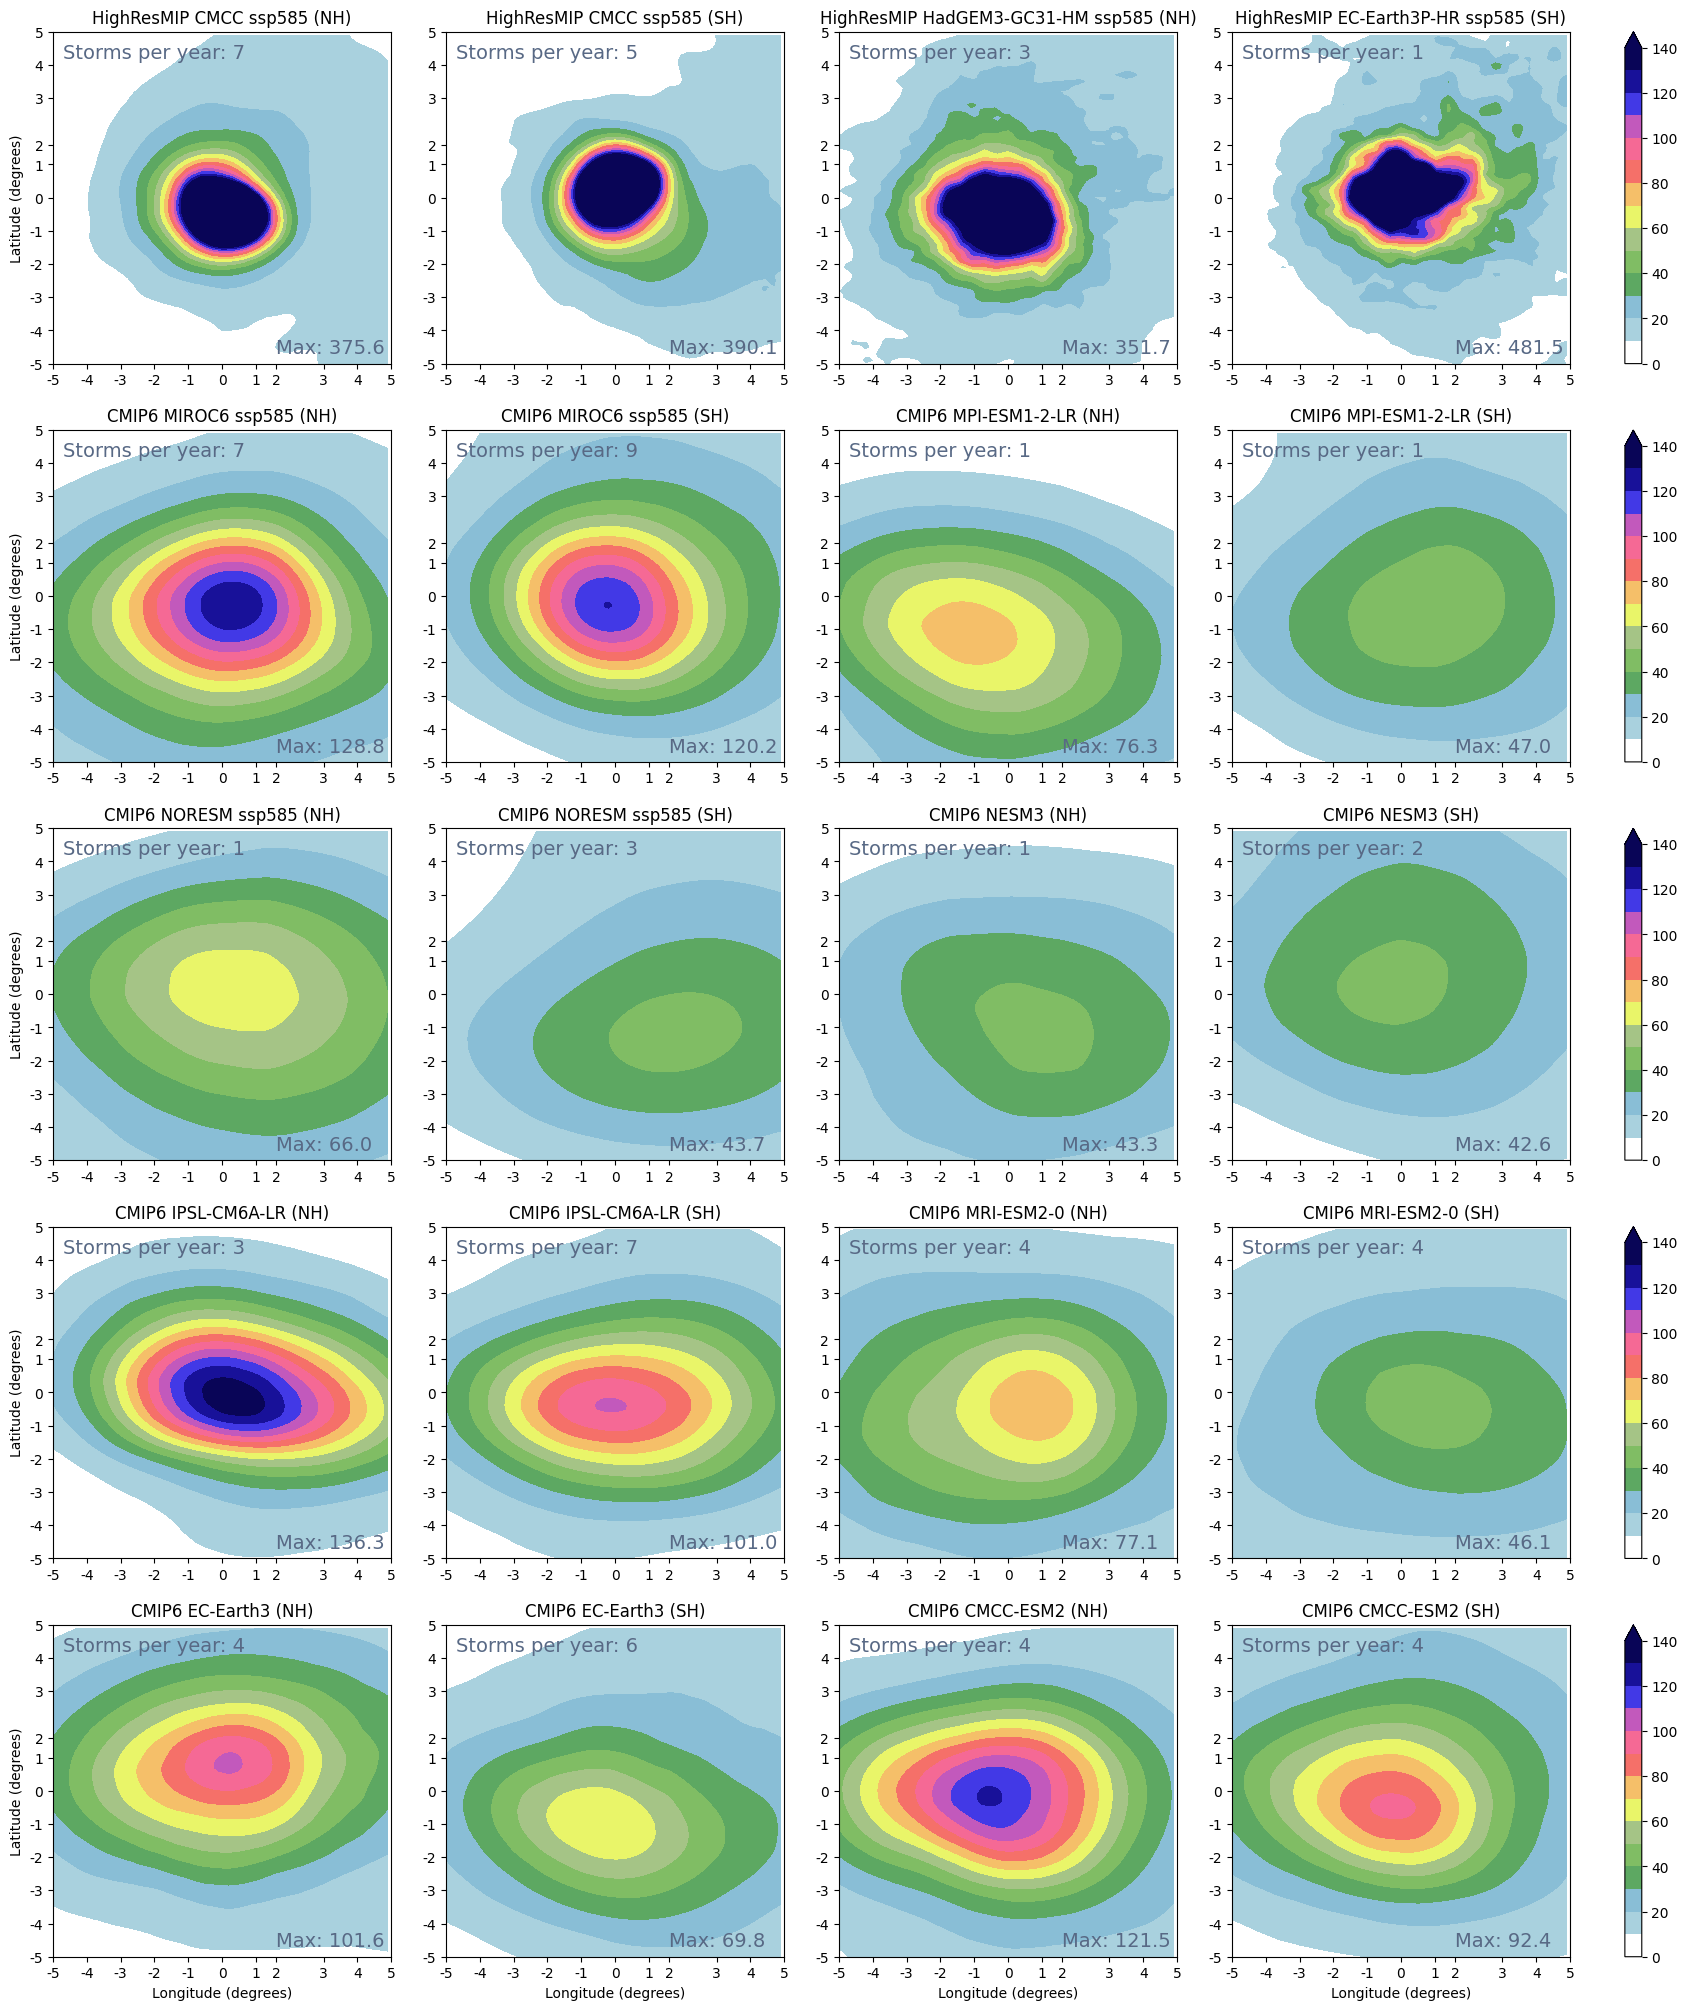

In [13]:

fig,axes = plt.subplots(5,5,figsize=(20.5, 25),gridspec_kw={'width_ratios': [1, 1, 1, 1, 0.05]})

levels = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140]
# levels = [0,10,20,30,40,50,60,top_x,80,90,100,110,120,130,140,160,180,200,220,240]

top_x = 66
# HighresMIP
nyears = 35
im = axes[0,0].contourf(composite_CMCC_ssp585_NH,cmap=precip_cmap,levels=levels,extend='max')
axes[0,0].annotate('Max: %.1f' % np.max(composite_CMCC_ssp585_NH), xy = (90,90), xytext=(top_x,3),fontsize=14, color='#586985')
axes[0,0].annotate('Storms per year: %.0f' % (int(nstorms_CMCC_ssp585_nh) / nyears), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
axes[0,1].contourf(composite_CMCC_ssp585_SH,cmap=precip_cmap,levels=levels,extend='max')
axes[0,1].annotate('Max: %.1f' % np.max(composite_CMCC_ssp585_SH), xy = (90,90), xytext=(top_x,3),fontsize=14, color='#586985')
axes[0,1].annotate('Storms per year: %.0f' % (int(nstorms_CMCC_ssp585_sh) / nyears), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')

axes[0,2].contourf(composite_hadgem_ssp585_NH,cmap=precip_cmap,levels=levels,extend='max')
axes[0,2].annotate('Max: %.1f' % np.max(composite_hadgem_ssp585_NH), xy = (90,90), xytext=(top_x,3),fontsize=14, color='#586985')
axes[0,2].annotate('Storms per year: %.0f' % (int(nstorms_hadgem_ssp585_nh) / nyears), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
axes[0,3].contourf(composite_hadgem_ssp585_SH,cmap=precip_cmap,levels=levels,extend='max')
axes[0,3].annotate('Max: %.1f' % np.max(composite_hadgem_ssp585_SH), xy = (90,90), xytext=(top_x,3),fontsize=14, color='#586985')
axes[0,3].annotate('Storms per year: %.0f' % (int(nstorms_hadgem_ssp585_sh)  / nyears), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')

# CMIP6 ssp585
nyears = 30
axes[1,0].contourf(composite_miroc6_ssp585_nh,cmap=precip_cmap,levels=levels,extend='max')
axes[1,0].annotate('Max: %.1f' % np.max(composite_miroc6_ssp585_nh), xy = (90,90), xytext=(top_x,3),fontsize=14, color='#586985')
axes[1,0].annotate('Storms per year: %.0f' % (int(nstorms_miroc6_ssp585_nh) / nyears), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
axes[1,1].contourf(composite_miroc6_ssp585_sh,cmap=precip_cmap,levels=levels,extend='max')
axes[1,1].annotate('Max: %.1f' % np.max(composite_miroc6_ssp585_sh), xy = (90,90), xytext=(top_x,3),fontsize=14, color='#586985')
axes[1,1].annotate('Storms per year: %.0f' % (int(nstorms_miroc6_ssp585_sh) / nyears), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')

axes[1,2].contourf(composite_mpi_ssp585_nh,cmap=precip_cmap,levels=levels,extend='max')
axes[1,2].annotate('Max: %.1f' % np.max(composite_mpi_ssp585_nh), xy = (90,90), xytext=(top_x,3),fontsize=14, color='#586985')
axes[1,2].annotate('Storms per year: %.0f' % (int(nstorms_mpi_ssp585_nh) / nyears), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
axes[1,3].contourf(composite_mpi_ssp585_sh,cmap=precip_cmap,levels=levels,extend='max')
axes[1,3].annotate('Max: %.1f' % np.max(composite_mpi_ssp585_sh), xy = (90,90), xytext=(top_x,3),fontsize=14, color='#586985')
axes[1,3].annotate('Storms per year: %.0f' % (int(nstorms_mpi_ssp585_sh) / nyears), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')

axes[2,0].contourf(composite_noresm_ssp585_nh,cmap=precip_cmap,levels=levels,extend='max')
axes[2,0].annotate('Max: %.1f' % np.max(composite_noresm_ssp585_nh), xy = (90,90), xytext=(top_x,3),fontsize=14, color='#586985')
axes[2,0].annotate('Storms per year: %.0f' % (int(nstorms_noresm_ssp585_nh) / nyears), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
axes[2,1].contourf(composite_noresm_ssp585_sh,cmap=precip_cmap,levels=levels,extend='max')
axes[2,1].annotate('Max: %.1f' % np.max(composite_noresm_ssp585_sh), xy = (90,90), xytext=(top_x,3),fontsize=14, color='#586985')
axes[2,1].annotate('Storms per year: %.0f' % (int(nstorms_noresm_ssp585_sh) / nyears), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')

axes[2,2].contourf(composite_nems_ssp585_nh,cmap=precip_cmap,levels=levels,extend='max')
axes[2,2].annotate('Max: %.1f' % np.max(composite_nems_ssp585_nh), xy = (90,90), xytext=(top_x,3),fontsize=14, color='#586985')
axes[2,2].annotate('Storms per year: %.0f' % (int(nstorms_nems_ssp585_nh) / nyears), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
axes[2,3].contourf(composite_nems_ssp585_sh,cmap=precip_cmap,levels=levels,extend='max')
axes[2,3].annotate('Max: %.1f' % np.max(composite_nems_ssp585_sh), xy = (90,90), xytext=(top_x,3),fontsize=14, color='#586985')
axes[2,3].annotate('Storms per year: %.0f' % (int(nstorms_nems_ssp585_sh) / nyears), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')

axes[3,0].contourf(composite_ipsl_ssp585_nh,cmap=precip_cmap,levels=levels,extend='max')
axes[3,0].annotate('Max: %.1f' % np.max(composite_ipsl_ssp585_nh), xy = (90,90), xytext=(top_x,3),fontsize=14, color='#586985')
axes[3,0].annotate('Storms per year: %.0f' % (int(nstorms_ipsl_ssp585_nh) / nyears), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
axes[3,1].contourf(composite_ipsl_ssp585_sh,cmap=precip_cmap,levels=levels,extend='max')
axes[3,1].annotate('Max: %.1f' % np.max(composite_ipsl_ssp585_sh), xy = (90,90), xytext=(top_x,3),fontsize=14, color='#586985')
axes[3,1].annotate('Storms per year: %.0f' % (int(nstorms_ipsl_ssp585_sh) / nyears), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')

axes[3,2].contourf(composite_mri_ssp585_nh,cmap=precip_cmap,levels=levels,extend='max')
axes[3,2].annotate('Max: %.1f' % np.max(composite_mri_ssp585_nh), xy = (90,90), xytext=(top_x,3),fontsize=14, color='#586985')
axes[3,2].annotate('Storms per year: %.0f' % (int(nstorms_mri_ssp585_nh) / nyears), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
axes[3,3].contourf(composite_mri_ssp585_sh,cmap=precip_cmap,levels=levels,extend='max')
axes[3,3].annotate('Max: %.1f' % np.max(composite_mri_ssp585_sh), xy = (90,90), xytext=(top_x,3),fontsize=14, color='#586985')
axes[3,3].annotate('Storms per year: %.0f' % (int(nstorms_mri_ssp585_sh) / nyears), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')

axes[4,0].contourf(composite_ecearth_ssp585_nh,cmap=precip_cmap,levels=levels,extend='max')
axes[4,0].annotate('Max: %.1f' % np.max(composite_ecearth_ssp585_nh), xy = (90,90), xytext=(top_x,3),fontsize=14, color='#586985')
axes[4,0].annotate('Storms per year: %.0f' % (int(nstorms_ecearth_ssp585_nh) / nyears), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
axes[4,1].contourf(composite_ecearth_ssp585_sh,cmap=precip_cmap,levels=levels,extend='max')
axes[4,1].annotate('Max: %.1f' % np.max(composite_ecearth_ssp585_sh), xy = (90,90), xytext=(top_x,3),fontsize=14, color='#586985')
axes[4,1].annotate('Storms per year: %.0f' % (int(nstorms_ecearth_ssp585_sh) / nyears), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')

axes[4,2].contourf(composite_cmcclr_ssp585_nh,cmap=precip_cmap,levels=levels,extend='max')
axes[4,2].annotate('Max: %.1f' % np.max(composite_cmcclr_ssp585_nh), xy = (90,90), xytext=(top_x,3),fontsize=14, color='#586985')
axes[4,2].annotate('Storms per year: %.0f' % (int(nstorms_cmcclr_ssp585_nh) / nyears), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
axes[4,3].contourf(composite_cmcclr_ssp585_sh,cmap=precip_cmap,levels=levels,extend='max')
axes[4,3].annotate('Max: %.1f' % np.max(composite_cmcclr_ssp585_sh), xy = (90,90), xytext=(top_x,3),fontsize=14, color='#586985')
axes[4,3].annotate('Storms per year: %.0f' % (int(nstorms_cmcclr_ssp585_sh) / nyears), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')

# Set the tick positions
t_p = [0,10,20,30,40,50,60,top_x,80,90,100]
t_l = [-5,-4,-3,-2,-1,0,1,2,3,4,5]
for i in range(5):
	for j in range(4):
		axes[i,j].set_xticks(t_p)
		axes[i,j].set_yticks(t_p)
		# Set the tick labels
		axes[i,j].set_xticklabels(t_l)
		axes[i,j].set_yticklabels(t_l)

for ax in [axes[0,0],axes[1,0],axes[2,0],axes[3,0],axes[4,0]]:
	ax.set_ylabel('Latitude (degrees)')
for ax in [axes[4,0],axes[4,1],axes[4,2],axes[4,3]]:
	ax.set_xlabel('Longitude (degrees)')

# axes[0,0].set_xlabel('Longitude (degrees)')
# axes[0,0].set_ylabel('Latitude (degrees)')

axes[0,0].set_title('HighResMIP CMCC ssp585 (NH)')
axes[0,1].set_title('HighResMIP CMCC ssp585 (SH)')
axes[0,3].set_title('HighResMIP EC-Earth3P-HR ssp585 (SH)')
axes[0,2].set_title('HighResMIP HadGEM3-GC31-HM ssp585 (NH)')

axes[1,0].set_title('CMIP6 MIROC6 ssp585 (NH)')
axes[1,1].set_title('CMIP6 MIROC6 ssp585 (SH)')
axes[1,2].set_title('CMIP6 MPI-ESM1-2-LR (NH)')
axes[1,3].set_title('CMIP6 MPI-ESM1-2-LR (SH)')

axes[2,0].set_title('CMIP6 NORESM ssp585 (NH)')
axes[2,1].set_title('CMIP6 NORESM ssp585 (SH)')
axes[2,2].set_title('CMIP6 NESM3 (NH)')
axes[2,3].set_title('CMIP6 NESM3 (SH)')

axes[3,0].set_title('CMIP6 IPSL-CM6A-LR (NH)')
axes[3,1].set_title('CMIP6 IPSL-CM6A-LR (SH)')
axes[3,2].set_title('CMIP6 MRI-ESM2-0 (NH)')
axes[3,3].set_title('CMIP6 MRI-ESM2-0 (SH)')

axes[4,0].set_title('CMIP6 EC-Earth3 (NH)')
axes[4,1].set_title('CMIP6 EC-Earth3 (SH)')
axes[4,2].set_title('CMIP6 CMCC-ESM2 (NH)')
axes[4,3].set_title('CMIP6 CMCC-ESM2 (SH)')

# axes[7,0].set_title('CMIP6 BCC-CSM2-MR (NH)')
# axes[7,1].set_title('CMIP6 BCC-CSM2-MR (SH)')

plt.colorbar(im,ticks=[0,20,40,60,80,100,120,140],cax=axes[0,4])
plt.colorbar(im,ticks=[0,20,40,60,80,100,120,140],cax=axes[1,4])
plt.colorbar(im,ticks=[0,20,40,60,80,100,120,140],cax=axes[2,4])
plt.colorbar(im,ticks=[0,20,40,60,80,100,120,140],cax=axes[3,4])
plt.colorbar(im,ticks=[0,20,40,60,80,100,120,140],cax=axes[4,4])


plt.savefig('composite_rain_ssp2.png',bbox_inches='tight')

In [12]:
# method for composite rain plot:
# for each storm, sum up the rain along its track, centred on centre of TC.
# convert units from mm/3hr rainfall to mm/day rainfall. THis requires knowing if the storm timesteps are sampled every 3 hours or every 6 hours
# for 3 hourly storms you add up and divide by number of timesteps (storm duration/number of hours storm was alive for as a TC) to get mm/hr then multiply by 24
# for 6 hourly storms you add up rain at 6 hour points and interpolate to get values for 3 hourly points (otherwise you're only adding up half the rainfall). Then divide by number of timesteps and multiply by 24
# split into nh and sh
# do the mean for each hemisphere


# save everything
fig_dir = '/user/home/al18709/work/figures/figure_1/'



# HighresMIP
np.save(fig_dir + 'composite_CMCC_ssp585_NH.npy',composite_CMCC_ssp585_NH)
np.save(fig_dir + 'composite_CMCC_ssp585_SH.npy',composite_CMCC_ssp585_SH)

np.save(fig_dir + 'composite_ecearthhr_ssp585_NH.npy',composite_ecearthhr_ssp585_NH)
np.save(fig_dir + 'composite_ecearthhr_ssp585_SH.npy',composite_ecearthhr_ssp585_SH)

np.save(fig_dir + 'composite_hadgem_ssp585_NH.npy',composite_hadgem_ssp585_NH)
np.save(fig_dir + 'composite_hadgem_ssp585_SH.npy',composite_hadgem_ssp585_SH)

# CMIP6 ssp585
np.save(fig_dir + 'composite_miroc6_ssp585_nh.npy',composite_miroc6_ssp585_nh)
np.save(fig_dir + 'composite_miroc6_ssp585_sh.npy',composite_miroc6_ssp585_sh)

np.save(fig_dir + 'composite_mpi_ssp585_nh.npy',composite_mpi_ssp585_nh)
np.save(fig_dir + 'composite_mpi_ssp585_sh.npy',composite_mpi_ssp585_sh)

np.save(fig_dir + 'composite_noresm_ssp585_nh.npy',composite_noresm_ssp585_nh)
np.save(fig_dir + 'composite_noresm_ssp585_sh.npy',composite_noresm_ssp585_sh)

# np.save(fig_dir + composite_taiesm_ssp585_nh,'composite_taiesm_ssp585_nh.npy')
# np.save(fig_dir + composite_taiesm_ssp585_sh,'composite_taiesm_ssp585_sh.npy')

np.save(fig_dir + 'composite_ipsl_ssp585_nh.npy',composite_ipsl_ssp585_nh)
np.save(fig_dir + 'composite_ipsl_ssp585_sh.npy',composite_ipsl_ssp585_sh)

np.save(fig_dir + 'composite_mri_ssp585_nh.npy',composite_mri_ssp585_nh)
np.save(fig_dir + 'composite_mri_ssp585_sh.npy',composite_mri_ssp585_sh)

np.save(fig_dir + 'composite_ecearth_ssp585_nh.npy',composite_ecearth_ssp585_nh)
np.save(fig_dir + 'composite_ecearth_ssp585_sh.npy',composite_ecearth_ssp585_sh)

np.save(fig_dir + 'composite_cmcclr_ssp585_nh.npy',composite_cmcclr_ssp585_nh)
np.save(fig_dir + 'composite_cmcclr_ssp585_sh.npy',composite_cmcclr_ssp585_sh)

# np.save(fig_dir + composite_bcc_ssp585_nh,'composite_bcc_ssp585_nh.npy')
# np.save(fig_dir + composite_bcc_ssp585_sh,'composite_bcc_ssp585_sh.npy')

np.save(fig_dir + 'composite_nems_ssp585_nh.npy',composite_nems_ssp585_nh)
np.save(fig_dir + 'composite_nems_ssp585_sh.npy',composite_nems_ssp585_sh)


# OG WGAN
# np.save(composite_og_nh,'composite_og_nh.npy')
# np.save(composite_og_sh,'composite_og_sh.npy')
# np.save(composite_og_x_nh,'composite_og_x_nh.npy')
# np.save(composite_og_x_nh,'composite_og_x_nh.npy')
# np.save(composite_og_x_sh,'composite_og_x_sh.npy')

# # Scalar WGAN
# np.save(composite_wgan_nh,'composite_wgan_nh.npy')
# np.save(composite_wgan_sh,'composite_wgan_sh.npy')
